# Описание проекта
  
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Шаг 1. Импорт данных и библиотек

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Данные получены. По первым строкам и общим данным ошибок нет, есть пропуски в необязательных столбцах и 2 пропуска в имени и жанре игры, которые нужно проверить. Так как столбцы с целочисленными значениями содержат пропуски и их не привести к int, типы данных корректны.

## Шаг 2. Подготовка данных  
Переименовываю столбцы для удобного обращения к ним:

In [4]:
df.columns = df.columns.str.lower()
df.columns.values[2] = 'year'

Проверяю все данные по столбцам по очереди:

#### name  
Проверяю наличие дубликатов:

In [5]:
df['name'].value_counts().head()

Need for Speed: Most Wanted    12
Madden NFL 07                   9
FIFA 14                         9
Ratatouille                     9
LEGO Marvel Super Heroes        9
Name: name, dtype: int64

In [6]:
df[df['name'] == 'Need for Speed: Most Wanted'].sort_values(by = 'year')

name platform    year   genre  na_sales  \
253    Need for Speed: Most Wanted      PS2  2005.0  Racing      2.03   
1591   Need for Speed: Most Wanted     X360  2005.0  Racing      1.00   
1998   Need for Speed: Most Wanted       XB  2005.0  Racing      0.53   
3581   Need for Speed: Most Wanted       GC  2005.0  Racing      0.43   
5972   Need for Speed: Most Wanted       PC  2005.0  Racing      0.02   
6410   Need for Speed: Most Wanted       DS  2005.0  Racing      0.24   
6473   Need for Speed: Most Wanted      GBA  2005.0  Racing      0.19   
523    Need for Speed: Most Wanted      PS3  2012.0  Racing      0.71   
1190   Need for Speed: Most Wanted     X360  2012.0  Racing      0.62   
2048   Need for Speed: Most Wanted      PSV  2012.0  Racing      0.33   
11715  Need for Speed: Most Wanted       PC  2012.0  Racing      0.00   
6273   Need for Speed: Most Wanted     WiiU  2013.0  Racing      0.13   

       eu_sales  jp_sales  other_sales  critic_score user_score rating  
253        1.79      0.08         0.47          82.0        9.1      T  
1591       0.13      0.02         0.10          83.0        8.5      T  
1998       0.46      0.00         0.05          83.0        8.8      T  
3581       0.11      0.00         0.02          80.0        9.1      T  
5972       0.23      0.00         0.04          82.0        8.5      T  
6410       0.01      0.00         0.02          45.0        6.1      E  
6473       0.07      0.00         0.00           NaN        8.3      E  
523        1.46      0.06         0.58           NaN        NaN    NaN  
1190       0.78      0.01         0.15          83.0        8.5      T  
2048       0.45      0.01         0.22           NaN        NaN    NaN  
11715      0.06      0.00         0.02          82.0        8.5      T  
6273       0.12      0.00         0.02           NaN        NaN    NaN

Быстрый поиск показывает, что под названием Need for Speed: Most Wanted действительно есть 2 игры 2005 и 2012 года, а из таблицы видно, что все дубликаты - это версии игры для разных платформ. Нужно проверить, есть ли полные дубликаты для 3 столбцов (название, платформа, год):

In [7]:
df[df.duplicated(subset=['name', 'platform', 'year'], keep = False) == True]

name platform    year   genre  na_sales  eu_sales  jp_sales  \
604    Madden NFL 13      PS3  2012.0  Sports      2.11      0.22      0.00   
659              NaN      GEN  1993.0     NaN      1.78      0.53      0.00   
14244            NaN      GEN  1993.0     NaN      0.00      0.00      0.03   
16230  Madden NFL 13      PS3  2012.0  Sports      0.00      0.01      0.00   

       other_sales  critic_score user_score rating  
604           0.23          83.0        5.5      E  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  
16230         0.00          83.0        5.5      E

Во-первых, найдены две строки с играми без названия и жанра. Эти безымянные игры без рейтингов можно удалить. Во-вторых, повтор строки Madden NFL 13 можно также удалить, так как он не содержит дополнительной информации.

In [8]:
df.dropna(subset = ['name'], inplace = True)
df = df[df.duplicated(subset=['name', 'platform', 'year']) == False]

#### platform

Чтобы анализировать платформы, их нужно сгруппировать вручную:

In [9]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [10]:
def platform_groupper(row):
    if row['platform'] in ['3DS', 'DS', 'Wii', 'WiiU', 'GC', 'N64', 'NES', 'SNES']:
        return 'Nintendo'
    elif row['platform'] in ['PS', 'PS2', 'PS3', 'PS4', 'PSV', 'PSP']:
        return 'PS'
    elif row['platform'] in ['X360', 'XB', 'XOne']:
        return 'XBox'
    elif row['platform'] in ['PC']:
        return 'PC'
    elif row['platform'] in ['GB', 'GBA']:
        return 'GameBoy'
    elif row['platform'] in ['2600']:
        return 'Atari'
    elif row['platform'] in ['GEN', 'SAT', 'DC']:
        return 'Sega'
    else:
        return 'other'

df['plat_group'] = df.apply(platform_groupper, axis = 1)

In [11]:
df.pivot_table(index= ['plat_group', 'platform'], values = 'name', aggfunc='count')

name
plat_group platform      
Atari      2600       133
GameBoy    GB          98
           GBA        822
Nintendo   3DS        520
           DS        2151
           GC         556
           N64        319
           NES         98
           SNES       239
           Wii       1320
           WiiU       147
PC         PC         974
PS         PS        1197
           PS2       2161
           PS3       1330
           PS4        392
           PSP       1209
           PSV        430
Sega       DC          52
           GEN         27
           SAT        173
XBox       X360      1262
           XB         824
           XOne       247
other      3DO          3
           GG           1
           NG          12
           PCFX         1
           SCD          6
           TG16         2
           WS           6

Проверяю, что в прочие попали действительно только старые единичные игры:

In [12]:
df[df['plat_group'] == 'other'].pivot_table(index= ['platform', 'year'], values = 'name', aggfunc='count')

name
platform year        
3DO      1994.0     1
         1995.0     2
GG       1992.0     1
NG       1993.0     2
         1994.0     4
         1995.0     4
         1996.0     2
PCFX     1996.0     1
SCD      1993.0     1
         1994.0     5
TG16     1995.0     2
WS       1999.0     2
         2000.0     2
         2001.0     2

#### year

In [13]:
len(df[df['year'].isnull() == True])

269

Пропуски можно частично восстановить на основе года выпуска той же игры на других платформах. Годы выпуска одной и той же игры на разных платформах могут не совпадать, но наверняка не сильно отличаются друг от друга, поэтому заполненные на основе названия игры значения лучше пропусков. Заполнять значения средним или на основе других параметров неточно и ухудшит качество данных.

In [14]:
def year_filler(row):
    if row['year'] != row['year']: #if NaN
        try:
            return df[df['name'] == row['name']]['year'].mean()
        except:
            return np.NaN
    else:
        return row['year']
        
df['year2'] = df.apply(year_filler, axis = 1) #сохраняю значения в отдельный столбец для проверки
df['year2'] = df['year2'].round()

print('Заполнено пропусков:', len(df[df['year'].isnull() == True]) - len(df[df['year2'].isnull() == True]), 
      'Осталось пропусков:', len(df[df['year2'].isnull() == True]))

Заполнено пропусков: 123 Осталось пропусков: 146


Гистограмма распределения по годам:

Text(0, 0.5, 'Количество выпущенных игр')

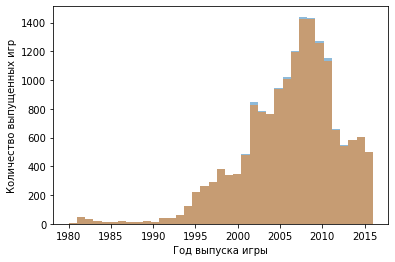

In [15]:
bins = df['year2'].max() - df['year2'].min() + 1
bins = bins.round().astype('int')
plt.hist(df.query('year2 == year2')['year2'], bins = bins, alpha = 0.5)
plt.hist(df.query('year == year')['year'], bins = bins, alpha = 0.5)
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество выпущенных игр')

Видно, что гистограммы совпадают, кроме того, что добавилось небольшое количество игр, которых не было до заполнения года, выбросов и расхождений нет. Гистограммы выглядят в целом корректно, хотя странно, что количество игр сокращается последние 10 лет. Можно оставить заполеннные значения в основной таблице:

In [16]:
df['year'] = df['year2']
del df['year2']

#### genre

In [17]:
df['genre'].value_counts()

Action          3369
Sports          2347
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

#### sales  
Детально оценивать количество продаж буду позднее, сейчас проверяю только наличие явно некорректных значений:

In [18]:
for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    print(region, df[region].min(), df[region].max())

na_sales 0.0 41.36
eu_sales 0.0 28.96
jp_sales 0.0 10.22
other_sales 0.0 10.57


Пропусков нет, минимальные значения неотрицательны, максимальные - реалистичны. Считаю общие продажи:

In [19]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

#### critic_score & user_score

Формат user_score - object, значит, в нем есть некорректные значения: 

In [20]:
df['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
0.2       2
2.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

tbd - to be done / determined - неизвестные значения, заменяю на пропуски:

In [21]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.NaN
df['user_score'] = df['user_score'].astype('float')

Кроме того user_score находится на шкале от 0 до 10, а critic_score - от 0 до 100. Делю critic_score на 10, чтобы привести к единой шкале для удобства анализа:

In [22]:
df['critic_score'] = df['critic_score']/10
df['critic_score'] = df['critic_score'].round(1)
for score in ['critic_score', 'user_score']:
    print(score, df[score].min(), df[score].max())

critic_score 1.3 9.8
user_score 0.0 9.7


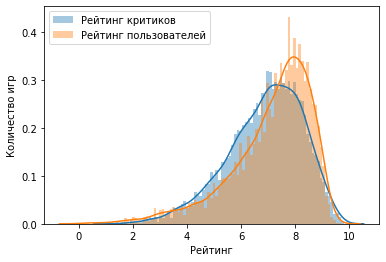

In [23]:
bins_critic_score = df['critic_score'].max()*10 - df['critic_score'].min()*10 + 1
bins_critic_score = bins_critic_score.astype('int')

bins_user_score = df['user_score'].max()*10 - df['user_score'].min()*10 + 1
bins_user_score = bins_user_score.astype('int')

ax = sns.distplot(df.query('critic_score == critic_score')['critic_score'], 
                  bins = bins_critic_score, label = 'Рейтинг критиков')
ax = sns.distplot(df.query('user_score == user_score')['user_score'], 
                  bins = bins_user_score, label = 'Рейтинг пользователей')

ax.set(xlabel='Рейтинг', ylabel='Количество игр')
plt.legend()

#### rating

In [24]:
df['rating'].value_counts()

E       3989
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

Так как рейтинги определяют возраст аудитории, для которой доступны игры, заменяю рейтинг минимальным возрастом аудитории для понятности. EC и KA означают Early Childhood и Kids to Adults, то есть доступны в любом возрасте. RP - Rating Pending - заменяю на NaN, чем он, по сути, и является.

In [25]:
df['rating'] = df['rating'].replace('E', 0)
df['rating'] = df['rating'].replace('K-A', 0)
df['rating'] = df['rating'].replace('EC', 0)
df['rating'] = df['rating'].replace('E10+', 10)
df['rating'] = df['rating'].replace('T', 13)
df['rating'] = df['rating'].replace('M', 17)
df['rating'] = df['rating'].replace('AO', 18)
df['rating'] = df['rating'].replace('RP', np.NaN)

#### Вывод:
Все значения и типы данных корректны. В некоторых столбцах остались пропуски, я не заполняю их, кроме года, так как нет достоверных источников. Удалять их также нет смысла. 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 13 columns):
name            16712 non-null object
platform        16712 non-null object
year            16566 non-null float64
genre           16712 non-null object
na_sales        16712 non-null float64
eu_sales        16712 non-null float64
jp_sales        16712 non-null float64
other_sales     16712 non-null float64
critic_score    8136 non-null float64
user_score      7589 non-null float64
rating          9945 non-null float64
plat_group      16712 non-null object
total_sales     16712 non-null float64
dtypes: float64(9), object(4)
memory usage: 1.8+ MB


## Шаг 3. Исследовательский анализ данных  
### Выбор актуального периода для анализа  
Распределение продаж игр по платформам и группам платформ по годам:

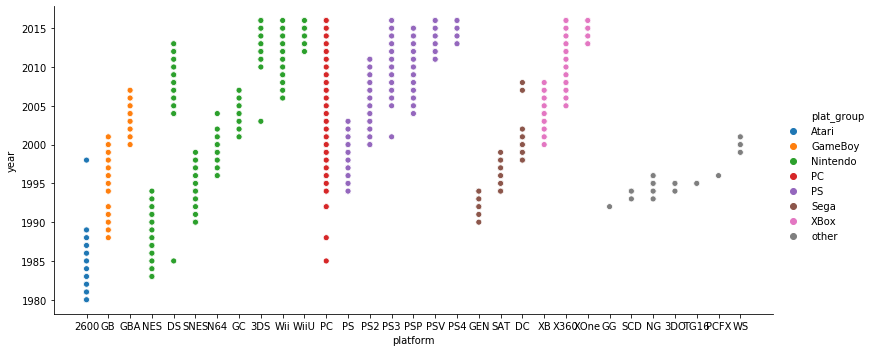

In [27]:
sns.relplot(x='platform', y='year', data=df.sort_values(by = ['plat_group', 'year']), 
                height =5, aspect = 2.2, hue = 'plat_group')

Если не считать PC, который, естественно, является неизменной платформой, и прочие, не имевшие популярности, платформы, то видно, что средний срок жизни платформы равен примерно 10 годам. Это можно проверить численно:

In [28]:
platforms = df.pivot_table(index = ['plat_group', 'platform'], values = 'year', aggfunc = ['min', 'max'])
platforms.columns = ['min', 'max']
platforms.reset_index(inplace=True)
platforms['lifespan'] = platforms['max'] - platforms['min']
platforms.sort_values(by='lifespan', ascending = False)

plat_group platform     min     max  lifespan
11         PC       PC  1985.0  2016.0      31.0
4    Nintendo       DS  1985.0  2013.0      28.0
0       Atari     2600  1980.0  1998.0      18.0
14         PS      PS3  2001.0  2016.0      15.0
3    Nintendo      3DS  2003.0  2016.0      13.0
1     GameBoy       GB  1988.0  2001.0      13.0
21       XBox     X360  2005.0  2016.0      11.0
16         PS      PSP  2004.0  2015.0      11.0
13         PS      PS2  2000.0  2011.0      11.0
7    Nintendo      NES  1983.0  1994.0      11.0
9    Nintendo      Wii  2006.0  2016.0      10.0
18       Sega       DC  1998.0  2008.0      10.0
12         PS       PS  1994.0  2003.0       9.0
8    Nintendo     SNES  1990.0  1999.0       9.0
6    Nintendo      N64  1996.0  2004.0       8.0
22       XBox       XB  2000.0  2008.0       8.0
2     GameBoy      GBA  2000.0  2007.0       7.0
5    Nintendo       GC  2001.0  2007.0       6.0
17         PS      PSV  2011.0  2016.0       5.0
20       Sega      SAT  1994.0  1999.0       5.0
10   Nintendo     WiiU  2012.0  2016.0       4.0
19       Sega      GEN  1990.0  1994.0       4.0
26      other       NG  1993.0  1996.0       3.0
15         PS      PS4  2013.0  2016.0       3.0
23       XBox     XOne  2013.0  2016.0       3.0
30      other       WS  1999.0  2001.0       2.0
24      other      3DO  1994.0  1995.0       1.0
28      other      SCD  1993.0  1994.0       1.0
25      other       GG  1992.0  1992.0       0.0
27      other     PCFX  1996.0  1996.0       0.0
29      other     TG16  1995.0  1995.0       0.0

Считаю медианную продолжительность жизни платформы, не учитывая ПК, прочие и платформы, выпущенные менее 10 лет назад, так как их жизненный цикл еще не закончен:

In [29]:
platforms.query('platform != "PC" and plat_group != "other" and min < 2007')['lifespan'].median()

10.0

[Text(0, 0.5, 'Количество игр'), Text(0.5, 0, 'Год')]

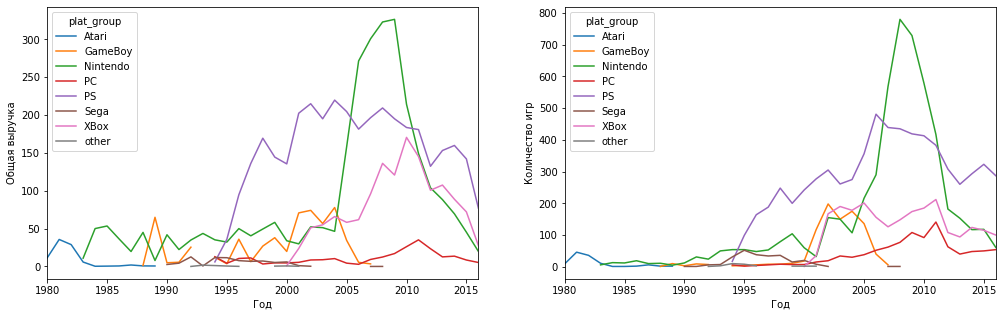

In [30]:
pivot_sum = df.pivot_table(index = 'year', columns = 'plat_group', values = 'total_sales', aggfunc = 'sum')
pivot_num = df.pivot_table(index = 'year', columns = 'plat_group', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,5))

pivot_sum.plot(kind = 'line', ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', ax=axes[1]).set(xlabel='Год', ylabel='Количество игр')

Выводы по графикам:    
1) Средняя продолжительность жизни одной платформы - 10 лет.  
2) В 2016 году продавались игры для 9 платформ 4 групп - ПК, PlayStation, Xbox и Nintendo.  
3) Последние игры для других платформ - Sega (DC) и GameBoy(GBA) были выпущены в 2007 и 2008 годах, на их закате.  
4) Максимальное количество продаж и по количеству, и по сумме достигнуто в 2008 году:

In [31]:
df.pivot_table(index = 'year', values = 'total_sales', aggfunc = ['count', 'sum']).idxmax() 

count  total_sales    2008.0
sum    total_sales    2008.0
dtype: float64

5) После 2008 года и количество, и объем продаж снизились примерно в 2,5 раза (без учета неполного 2016 года)

In [32]:
print(df[df['year'] == 2008]['total_sales'].sum() / df[df['year'] == 2015]['total_sales'].sum())
print(df[df['year'] == 2008]['name'].count() / df[df['year'] == 2015]['name'].count())

2.542130009702217
2.377887788778878


Это могло произойти по разным причинам:  
- выход одной или нескольких сверхпопулярных игр конкретно в 2008 и соседние годы
- в целом индустрия игр на ПК и приставках снижается с 2008 года за счет кокуренции со стороны мобильных игр для смартфонов
- в целом индустрия игр на ПК и приставках снижается с 2008 года из-за финансового кризиса 2008 года и снижения покупательной способности населения
- продажи игр считаются накопительно за все годы и чем раньше появилась игра, тем больше у нее накапливается продаж со временем 
- собранные данные неполные и не учитывают новые каналы продаж в последние годы  
Чтобы проверить первую гипотезу, достаточно посмотреть список наиболее продаваемых игр за всю историю:

In [33]:
pivot = df.pivot_table(index = ['name', 'year'], values = 'total_sales', aggfunc = 'sum')
pivot.reset_index(inplace=True)
pivot.sort_values(by = 'total_sales', ascending = False).head(10)

name    year  total_sales
11703                      Wii Sports  2006.0        82.54
9910                Super Mario Bros.  1985.0        40.24
3966               Grand Theft Auto V  2013.0        37.32
5894                   Mario Kart Wii  2008.0        35.52
11705               Wii Sports Resort  2009.0        32.77
7778         Pokemon Red/Pokemon Blue  1996.0        31.38
1322          Call of Duty: Black Ops  2010.0        30.82
1329   Call of Duty: Modern Warfare 3  2011.0        30.60
10328                          Tetris  1989.0        30.26
7120            New Super Mario Bros.  2006.0        29.80

Первая гипотеза не подтвердилась, в топ-10 только одна игра из 2008, значит, продажи в 2008 году больше за счет количества игр, а не отдельных хитов.  
Проверяю вторую гипотезу - очевидно, что период снижения продаж на приставках совпал с ростом аудитории игр на смартфонах, однако неизвестно, является ли это единственной причиной. Добавляю столбец plat_type со значениями Pocket, Station(ary) и PC для мобильных и стационарных приставок и ПК и повторяю графики продаж только по этим группам:

In [34]:
def platform_type(row):
    if row['platform'] in ['PSP', 'PSV', 'WiiU', 'DS', 'GBA', '3DS', 'GB', '']:
        return 'Pocket'
    if row['platform'] in ['PC']:
        return 'PC'
    else:
        return 'Station'

df['plat_type'] = df.apply(platform_type, axis = 1)

[Text(0, 0.5, 'Количество игр'), Text(0.5, 0, 'Год')]

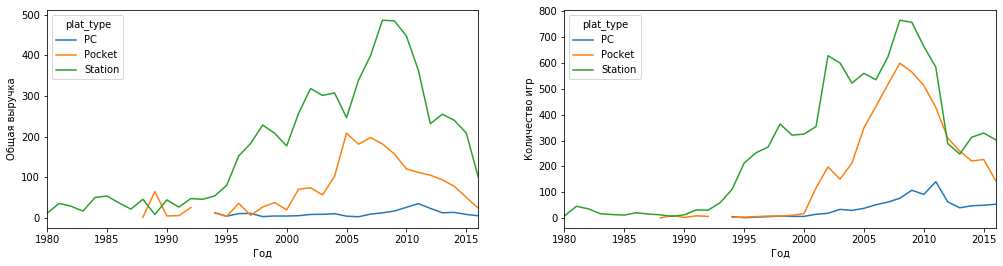

In [35]:
pivot_sum = df.pivot_table(index = 'year', columns = 'plat_type', values = 'total_sales', aggfunc = 'sum')
pivot_num = df.pivot_table(index = 'year', columns = 'plat_type', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,4))

pivot_sum.plot(kind = 'line', ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', ax=axes[1]).set(xlabel='Год', ylabel='Количество игр')

In [36]:
print('Год, доля продаж игр для портативных платформ:')
for year in df[df['year'] > 2007]['year'].sort_values().unique():
    print(year, df.query('plat_type == "Pocket" and year == @year')['total_sales'].sum() / df.query('year == @year')['total_sales'].sum())

Год, доля продаж игр для портативных платформ:
2008.0 0.2673360342904116
2009.0 0.23857106033267114
2010.0 0.20295631116940774
2011.0 0.21931491020192329
2012.0 0.2916146570136751
2013.0 0.25909442724458204
2014.0 0.23481378811618658
2015.0 0.18844689902231507
2016.0 0.18462367246421427


Как видно на графиках и в таблице, доля портативных платформ начала снижаться только после 2013 года, то есть основное снижение с 2008 года происходило одинаково и для портативных, и для стационарных консолей. Если бы дело было в смартфонах, падение стационарных приставок было бы гораздо меньше.  
Финансовый кризис абсолютно точно должен был повлиять на падение продаж игр, выпущенных после 2008 года: во-первых, геймеры могли позволить себе покупать меньше игр в целом, а во-вторых, покупать подешевшие игры предыдущих лет. Однако нет возможности проверить это численно или статистически и учесть это в анализе.

In [37]:
pivot = df.query('year > 2003').pivot_table(index = 'year', values = 'total_sales', aggfunc = ('sum', 'count'))
pivot.columns = ['Количество', 'Выручка']
pivot['Средняя выручка'] = pivot['Выручка'] / pivot['Количество']
pivot['Средняя выручка'] = pivot['Средняя выручка'].round(2)
pivot

Количество  Выручка  Средняя выручка
year                                        
2004.0         765   420.51             0.55
2005.0         947   459.96             0.49
2006.0        1019   523.17             0.51
2007.0        1202   606.16             0.50
2008.0        1441   681.24             0.47
2009.0        1430   659.51             0.46
2010.0        1269   594.66             0.47
2011.0        1153   510.59             0.44
2012.0         661   360.51             0.55
2013.0         547   361.76             0.66
2014.0         582   331.88             0.57
2015.0         606   267.98             0.44
2016.0         502   129.94             0.26

In [38]:
for i in range(10,13):
    decrease = (pivot.iloc[i,2] / pivot.iloc[9,2])
    print(round(decrease, 2))

0.86
0.67
0.39


Как видно из средней выручки на 1 игру, этот показатель оставался стабильным в течение долгого периода и даже рос в 2011 - 2013 годах, однако начал снижаться в 2013-2015 годах. То есть эффект влияния покупок в течение нескольких лет после выхода игры вероятно присутствует (если не объясняется другими факторами) на сроке до 3-4 лет. Если исходить из примерно стабильной выручки с 2013 года, к концу года выхода игра в среднем собирает 39% выручки, за 2 года - 67%, за 3 - 86%, и наконец, за 4 года - полную выручку. Но этот эффект не объясняет снижение выручки в 2008-2012 гг., так как после этого прошло достаточно времени, чтобы его нивелировать.  
Оставшуюся гипотезу (неполные данные) нельзя однозначно проверить на имеющихся данных, чтобы определить, какая доля изменений прихолится на эту причину, и какая - на прочие. Но для дальнейшего анализа они не имеют большой разницы с точки зрения влияния на прогноз выручки 2017 года. Важно то, что, по имеющимся у магазина данным, а значит, и каналам продаж, количество продаваемых игр и выручка снизились за последние 10 лет, хотя в последние годы это снижение прекратилось. Важно учитывать, что данные за 2016 год неполные, поэтому на абсолютные показатели 2016 года нужно смотреть осторожно.

Гипотезы причины снижения продаж с 2008 года:  
- выход одной или нескольких сверхпопулярных игр конкретно в 2008 и соседние годы - **опровергнута**
- в целом индустрия игр на ПК и приставках снижается с 2008 года за счет конкуренции со стороны мобильных игр для смартфонов -  **не подтвердилась**
- в целом индустрия игр на ПК и приставках снижается с 2008 года из-за финансового кризиса 2008 года и снижения покупательной способности населения - **эффект наверняка есть, однако невозможно оценить степень его влияния**
- продажи игр считаются накопительно за все годы и чем раньше появилась игра, тем больше у нее накапливается продаж со временем - **не подтвердилась, эффект присутсвует, однако на меньшем сроке**
- собранные данные неполные и не учитывают новые каналы продаж в последние годы - **невозможно подтвердить или опровергнуть**  
  
Учитывая снижение выручки более чем в два раза с 2008 года, строить тренды с этого периода неправильно. Платформы, появившиеся 10 лет назад, уже заканчивают свой жизненный цикл. Поэтому я беру данные за 5 лет, как половину от жизненного цикла платформы. Также можно оценить выручку платформ, чтобы отсечь неактуальные для цели анализа:

In [39]:
pivot = (df.query('year > 2011')
          .pivot_table(index = ['plat_group', 'plat_type', 'platform'], values = 'total_sales', aggfunc = 'sum')
          .sort_values(by = 'total_sales', ascending = False))
pivot.reset_index(inplace=True)
pivot

plat_group plat_type platform  total_sales
0          PS   Station      PS4       314.14
1          PS   Station      PS3       289.70
2        XBox   Station     X360       237.52
3    Nintendo    Pocket      3DS       195.01
4        XBox   Station     XOne       159.32
5    Nintendo    Pocket     WiiU        82.19
6          PC        PC       PC        63.51
7          PS    Pocket      PSV        49.18
8    Nintendo   Station      Wii        36.60
9    Nintendo    Pocket       DS        13.21
10         PS    Pocket      PSP        11.69

Границу по выручке устанавливаю на уровне 30 миллионов долларов, чтобы отсечь 2 платформы, под которые, к тому же, уже не выпускается игр. Для дальнейшего анализа я оставляю только эти данные:

In [40]:
df5 = df.query('year > 2011 and platform != "DS" and platform != "PSP"')

Чтобы оценить тренды уже по очищенным данным, снова смотрю графики количества игр и продаж:

[Text(0, 0.5, 'Количество игр'), Text(0.5, 0, 'Год')]

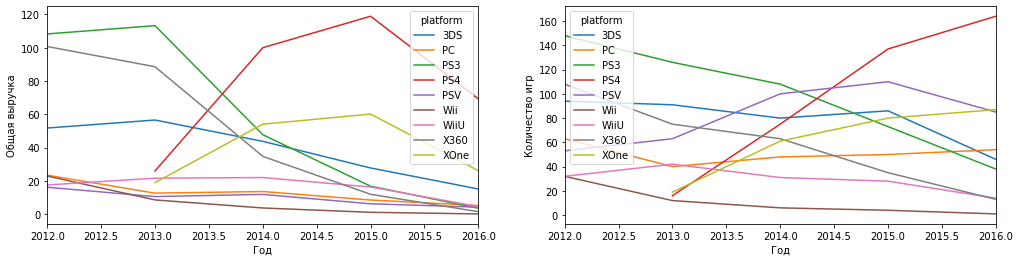

In [41]:
pivot_sum = df5.pivot_table(index = 'year', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
pivot_num = df5.pivot_table(index = 'year', columns = 'platform', values = 'name', aggfunc = 'count')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (17,4))

pivot_sum.plot(kind = 'line', ax=axes[0]).set(xlabel='Год', ylabel='Общая выручка')
pivot_num.plot(kind = 'line', ax=axes[1]).set(xlabel='Год', ylabel='Количество игр')

Основные тренды на этом горизонте:
- понижающийся тренд с 2008 года выровнялся, однако в 2015 году (и неполном 2016) выручка значительно ниже, чем в 2014 при растущем количестве игр. Маловероятно, что стоимость игр снижается, поэтому это косвенно подтверждает то, что игры продолжают покупать в последующие после выпуска годы. Таким образом, можно считать, что рынок игр рос в 2013-2015 годах. 

In [42]:
df5.pivot_table(index = 'year', values = 'total_sales', aggfunc = ('sum', 'count'))

count     sum
year                 
2012.0    530  340.89
2013.0    484  356.84
2014.0    572  331.64
2015.0    603  267.86
2016.0    502  129.94

- PS4 расчет за счет PS3 и лидирует и по выручке, и по количеству игр
- На втором месте - XBox One
- PSVita и ПК занимают 3 и 4 места и растут по количеству игр, но отстают по выручке, что говорит или о низкой средней выручке игр, или о неполных данных.  

Среднюю выручку с игры можно увидеть через распределение:

(0, 2)

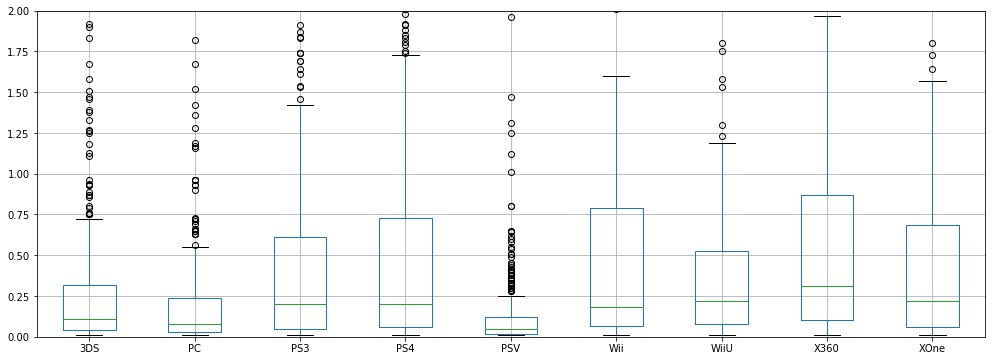

In [43]:
fig, ax = plt.subplots(figsize = (17,6))
df5.pivot_table(index = 'name', columns = 'platform', values = 'total_sales').boxplot(ax=ax, grid = True)
ax.set_ylim(0,2)

На диаграмме рахмаха видно, что по стоимости (как медианной, так и медиане +1,5 мкр) лидируют главные стационарные консоли: X360, Wii, PS4. Интересно, что PS4 обгоняет предыдущую версию PS3, но XOne отстает от более старой X360. А среди портативных платформ выручка WiiU значительно выше PSVita. ПК и Nintendo в целом отстают от лидером по всем параметрам.  
  
Далее я проверяю **влияние рейтингов на выручку игр**. Для начала нужно понять, насколько коррелируют рейтинги критиков и пользователей на примере лидирующей платформы - PS4: 

In [44]:
sample = df5.query('platform == "PS4"')
sample = sample.loc[:,['critic_score', 'user_score', 'total_sales']]
sample = sample.dropna()
sample.corr()

critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.405895
user_score        0.557654    1.000000    -0.033625
total_sales       0.405895   -0.033625     1.000000

Корреляция недостаточно сильная, чтобы строить интегральный рейтинг, поэтому нужно строить график по трем показателям.

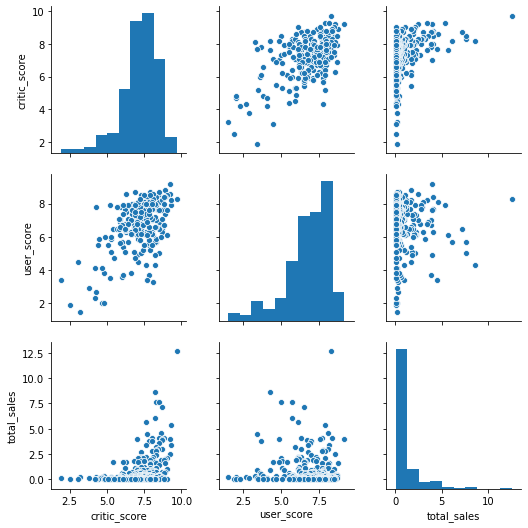

In [45]:
sample = sample[sample['total_sales']!=0]
sns.pairplot(sample)

Выводы по влиянию рейтингов на выручку игр:
- рейтинг критиков сильнее связан с выручкой игр, чем рейтинг пользователей. Здесь даже можно говорить именно о влиянии, а не корреляции, так как обзоры критиков выходят в первые дни появления игры.
- в целом, цепочка следующая: игра выходит - критики ставят оценку - пользователи принимают решение о покупке - пользователи играют и ставят оценку. Очевидно, что оценка критиков выходит до, а пользователей - после того, как они сыграют, поэтому связь с популряностью не такая прямая.
- оценки пользователей и критиков распределены примерно симметрично, что говорит об адекватности шкал оценки, полученной разными способами
- в целом, большое количество игр с околонулевой выручкой сильно влияет на коэффициент корреляции, поэтому он не может быть высоким. Если отсекать низкие значения или сделать логарифмическую шкалу выручки, результат бы был выше, но сейчас это не нужно.  
- выручка и рейтинги связаны сильнее, чем можно подумать, исходя из коэффициента корреляции. Игры с оценкой критиков ниже 5 вообще почти не продаются, а чтобы получить 4 миллионов долларов выручки с консолей PS4, нужен рейтинг не ниже 7. Оценка пользователей отличается - есть популярные (4 миллионов долларов выручки) игры с оценкой ниже 4. Помимо названной выше причины, у этого могут быть причины в виде количества рейтингов (чем больше оценок, тем меньше вероятность высокой средней), завышенных ожиданий, покупок самой популярной игры, а не той, которая действительно нужна.

**Распределение выручки игр по жанрам**

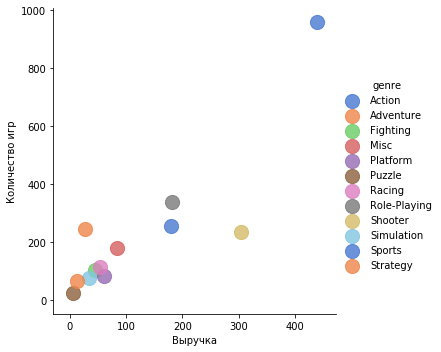

In [46]:
pivot = df5.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ['sum', 'count'])
pivot.columns = ['sum', 'count']
pivot.reset_index(inplace=True)
g = sns.lmplot(x='sum', y='count', hue='genre', truncate=True, data=pivot, palette="muted", scatter_kws={"s": 200})
g.set(xlabel='Выручка', ylabel='Количество игр')

- все жанры лежат достаточно близко к диагональной оси графика, то есть средняя выручка на одну игру примерно одинаковая (0,53 млн долл.). Выделяются только более дорогие шутеры (1,29 млн долл. на 1 игру) и более дешевые приключенческие игры (0,11 млн долл.)
- в безусловных лидерах экшн, также популярны RPG, шутеры (которые максимально близки к экшн) и спортивные.

## Шаг 4. Анализ портрета пользователя каждого региона  

### Самые популярные платформы для каждого региона:  
В абсолютных значениях Япония проигрывает Европе и Северной Америке (СА) по продажам, неудивительно, так как это одна страна, а не несколько:

In [47]:
for i in ['jp_sales', 'na_sales', 'eu_sales']:
    print(i, df5[i].sum())

jp_sales 178.39000000000001
na_sales 588.14
eu_sales 504.87


Поэтому для оценки популярности платформ в каждом регионе я сравниваю процентные, а не абсолютные значения:

In [48]:
def horizontal_table(parameter):
    # делаю сводную таблицу по продажам в каждом регионе по платформам
    pivot = df5.pivot_table(index = parameter, values = ['jp_sales', 'na_sales', 'eu_sales', 'total_sales'], aggfunc = 'sum')
    pivot.columns = ['EU', 'JP', 'NA', 'Total']
    pivot = pivot.sort_values(by = 'Total', ascending = False)
    pivot['EU%'] = pivot['EU'] / pivot['EU'].sum() # добавляю столбцы с процентной долей от итога
    pivot['JP%'] = pivot['JP'] / pivot['JP'].sum()
    pivot['NA%'] = pivot['NA'] / pivot['NA'].sum()
    pivot['Total%'] = pivot['Total'] / pivot['Total'].sum()
    pivot = pivot.drop(['EU', 'JP', 'NA', 'Total'], axis=1) # убираю столбцы с абсолютными значениями
     #для каждой следующей строки добавляю значение предыдущих
    for country in range (0,4):
        i = 0
        for j in range(0,len(pivot)):
            i += pivot.iloc[j,country]
            pivot.iloc[j,country] = i
    pivot = pivot.transpose() #поворачиваю таблицу, чтобы было удобнее строить график
    pivot = pivot.reset_index()
    pivot.rename(columns = {'index':parameter}, inplace = True)
    
    f, ax = plt.subplots(figsize=(15, 5)) #строю график
    for j in range (0,len(pivot.columns)-1):
        i = len(pivot.columns) - 2 - j
        sns.barplot(x = pivot.columns[i+1], y=parameter, data=pivot, label=pivot.columns[i+1], color = plt.cm.tab20(i))
    ax.set(ylabel='Регион', xlabel='Процентная доля каждого элемента в продажах')
    ax.legend(loc=(1, 0.1))

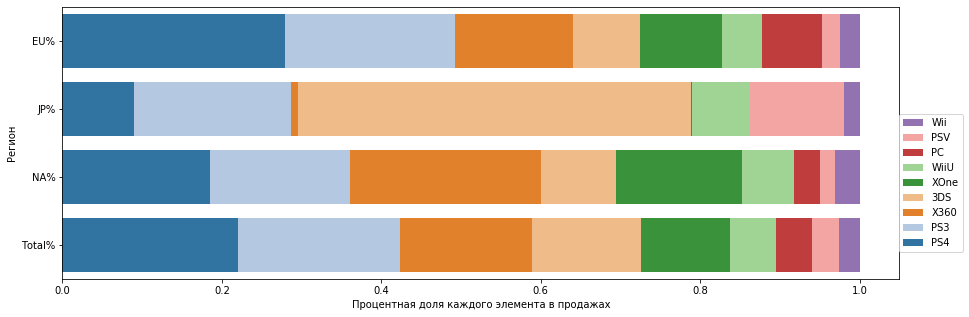

In [49]:
pivot = horizontal_table('platform')

**Выводы по графику:**  
- топ-5 платформ составляют примерно 80% продаж;
- доли отдельных платформ в Европе и СА примерно похожи с той разницей, что PS4 и PS3 более популряны в Европе, а XBox 360 и XOne - в СА;
- в Японии распределение популряности платформ отличается: на первом месте японская Nintendo 3DS, а аудитория XBox 360 и XOne почти отсутствует;
- В Европе и СА новая PS4 более популярна, чем PS3, а в Японии - наоборот, и проигрывает не только PS3, но даже PSVita;
- Как ни странно, доля японских Nintendo Wii и WiiU в Японии не намного выше, чем в Европе и СА;
- Игры на ПК лучше всего продаются в Европе, в СА - меньше, а в Японии - вообще нет.  
  
**Общий вывод:**  
Япония тяготеет к карманным (3DS, PSV) приставкам, Европа - к PlayStation, а США - к XBox. Если японцы и покупают стационарные приставки, то это PlayStation, поэтому в продажах по всему миру PlayStation обгоняет XBox. На платформы за пределами топ-5 приходится менее 20% продаж и их можно не анализировать.

### Самые популярные платформы для каждого региона: 
Строю аналогичный график по жанрам:

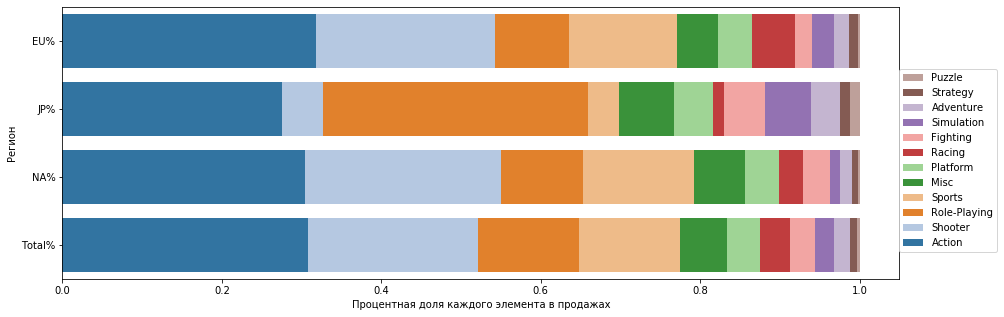

In [50]:
horizontal_table('genre')

**Выводы по графику:**  
- action составляет 30% продаж во всех регионах;
- топ-3 жанра (+ shooter и RPG) составляют 65% продаж;
- топ-5 (+ спортивные и некие прочие) - 80%;
- однако внутри этих распределений кроются различия: так же, как и с платформами, доли отдельных жанров в Европе и СА практически совпадают, а вот в Японии на первое место выходит RPG за счет доли шутеров и спортивных игр. Возможно, это связано с тем, что эти жанры более распространены на портативных приставках.

In [51]:
for i in ['Role-Playing', 'Shooter', 'Sports']:
    print (i, df.query('genre == @i and plat_type == "Pocket"')['total_sales'].sum() / df.query('genre == @i')['total_sales'].sum())

Role-Playing 0.45510186611881537
Shooter 0.041256116680127325
Sports 0.08401063653981944


Гипотеза подтвердилась: 46% процентов RPG выходят на портативных приставках, которые так популярны в Японии, в отличие от 4% шутеров и 8% спортивных, поэтому RPG отъел их доли в продажах.  
**Общий вывод:**  
Основные продажи приходятся на 5 жанров: action, shooter, RPG, спортивные и прочие. Предпочтения в разных регионах в целом совпадают и отличаются только в Японии за счет распространенности портативных платформ, жанры игр для которых отличаются.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

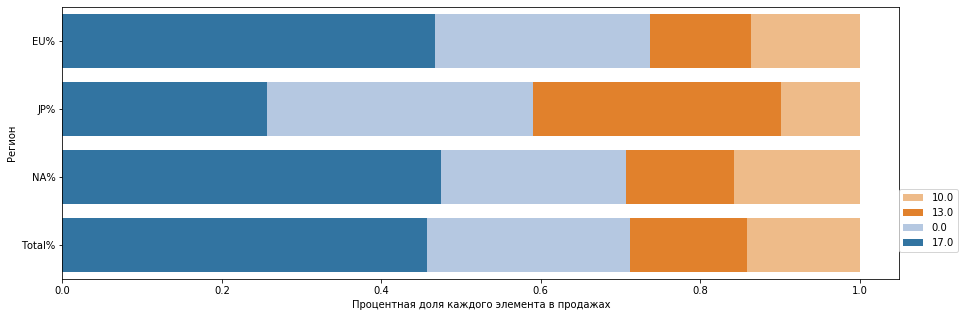

In [52]:
horizontal_table('rating')

**Выводы по графику:**  
- В Европе и СА, а также в мире в целом, наиболее популярны игры для взрослых (если быть точнее, зрелых (mature) - от 17 лет), 45%, и для аудитории всех возрастов - еще 25%. Рейтинги для детей от 10 и 13 лет более узкие и поэтому на них приходится меньшая доля игр.
- Как обычно, Япония значительно отличается от Европы и СА: рейтинги 0, 13 и 17 распределены примерно одинаково - по 25%-30%, то есть игры с рейтингом 13+ отнимают долю продаж от 17+. Чтобы выяснить причину этого, нужно оценить влияние игр, уникальных для Японии.
  
В целом, выводы по Японии сильно отличаются от Европы и Северной Америки. Для понимания причин я создаю датасет с играми, которые продаются только в Японии. Верхнеуровнево возможны 2 гипотезы:  
1) Для японского рынка выпускаются отдельные игры, специфические для этой страны (с рейтингом 13+, для карманных приставок, с большой долей RPG или другими тенденциями), которые не продаются в других странах.  
2) Если доля игр, выпускающихся для Японии, невелика  в общем числе продаж, или среди них нет выделенных тенденций по платформам, жанрам и рейтингу, то можно предположить, что в Японии покупаются те же игры, что и во всем мире, но распределение продаж среди них отличается.  
  
Предполагаю, что анализировать игры, продающиеся только в Европе и СА, нет смысла, так как в них не будет специфики. Для начала можно проверить объем продаж, приходящийся на игры, выпускаемые только для одного региона:

In [53]:
print('Доля продаж уникальных игр в Японии:{:.0%}'.format(
    df5.query('na_sales == 0 and eu_sales == 0 and jp_sales !=0')['jp_sales'].sum() / df5['jp_sales'].sum()))
print('Доля продаж уникальных игр в Европе:{:.0%}'.format(
    df5.query('na_sales == 0 and eu_sales != 0 and jp_sales ==0')['eu_sales'].sum() / df5['eu_sales'].sum()))
print('Доля продаж уникальных игр в Северной Америке:{:.0%}'.format(
    df5.query('na_sales != 0 and eu_sales == 0 and jp_sales ==0')['na_sales'].sum() / df5['na_sales'].sum()))

Доля продаж уникальных игр в Японии:37%
Доля продаж уникальных игр в Европе:3%
Доля продаж уникальных игр в Северной Америке:3%


Ч.Т.Д. 37% продаж игр в Японии приходится на игры, которые не продаются больше нигде в мире (по крайней мере, в Европе и СА и только по имеющимся данным). Далее сравниваю только игры, специфические для Японии, с общемировыми. Так как я хочу понять причины, почему та или иная доля продаж приходится на определенную категорию, я сравниваю *количество* игр, а не объем продаж, доля которого по платформам, жанрам и рейтингам уже известна. 

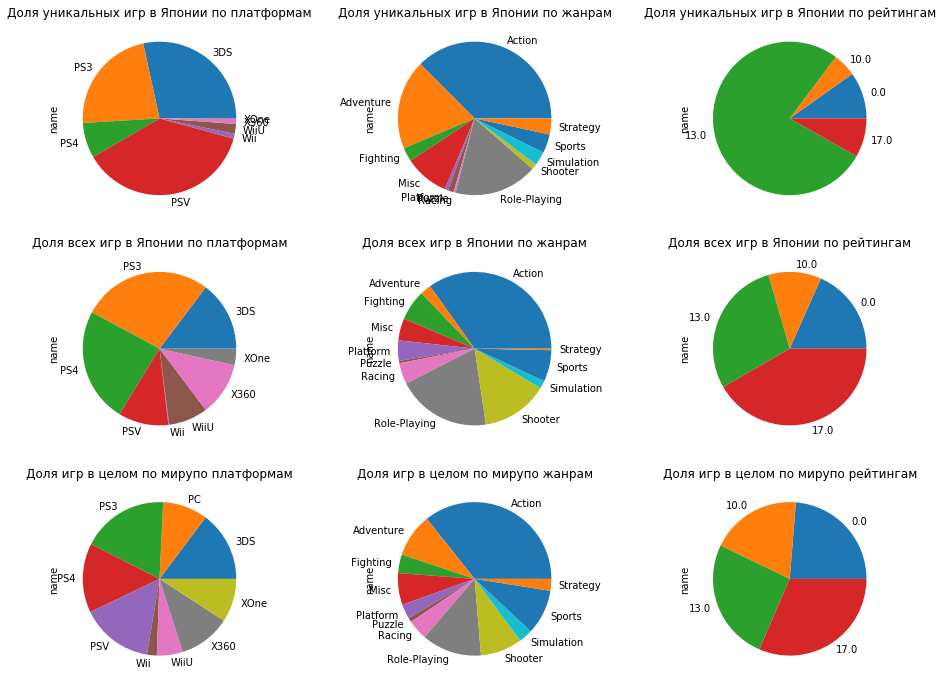

In [54]:
jp_unique = df5.query('na_sales == 0 and eu_sales == 0 and jp_sales !=0')
jp_common = df5.query('na_sales != 0 and eu_sales != 0 and jp_sales !=0')

datasets = [jp_unique, jp_common, df5]
indices = ['platform', 'genre' ,'rating']
title1 = ['Доля уникальных игр в Японии ', 'Доля всех игр в Японии ', 'Доля игр в целом по миру']
title2 = ['по платформам', 'по жанрам', 'по рейтингам']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (16,12))
for i in range(0, len(indices)):
    for j in range(0, len(datasets)):
        datasets[j].pivot_table(index = indices[i], values = 'name', aggfunc = 'count').plot(x = indices[i], y = 'name', kind = 'pie', ax=axes[j,i], legend = False, title = (title1[j]+title2[i]))

**Выводы по графикам:**  
- Платформы: уникальные для Японии игры выпускают на тех платформах, которые там популярны - Nintendo 3DS, PS Vita, PS3. Ничего удивительного.  
- Жанры: неожиданно, среди жанров уникальных игр выделяется не RPG, который отличался в объеме продаж, а приключения. Таким образом, подтвердилось предположение, что RPG популярны в Японии не из-за предпочтений местных геймеров, а просто потому, что в мире выпускается много RPG на популярные в Японии платформы, это может быть связано с особенностями контроллеров карманных приставок, на которых не так удобно играть в шутеры или экшн. В жанре приключений выпускается много местных игр (в 2 раза больше, чем в мире), однако на них приходится незначительная доля выручки, так же, как и в мире. Предположительно, это простые аркадные игры.  
- Рейтинг: ожидание, что на продажи игр с рейтингом 13+ влияют уникальные для Японии игры, полностью подтвердилось. Среди глобальных игр на Японию приходится бóльшая доля игр с рейтингами 17+ и 13+, но распределение близко к общемировому. А вот среди уникальных для Японии игр рейтинг 13+ имеют 3/4! Так как 37% продаж приходится на уникальные игры, неудивительно, что в итоговых продажах виден сдвиг в сторону этого возрастного рейтинга. Так как уникальные японские игры не продаются в США, большая часть не имеет рейтинга, присваимаеого амераканской ESRB, поэтому анализировать на уровне отдельных игр не имеет смысла. Возможно, отклонения связаны с маленькой выборкой, однако нет причин, почему общие тренды, выделенные среди игр с рейтингом, не относятся ко всем местным играм.

In [55]:
print('Продажи в Японии уникальных игр без известного рейтинга, млн. долл.: {:.0f}'
      .format(jp_unique[jp_unique['rating'] != jp_unique['rating']]['jp_sales'].sum()))
print('Продажи в Японии уникальных игр с известным рейтингом, млн. долл.: {:.0f}'
      .format(jp_unique[jp_unique['rating'] == jp_unique['rating']]['jp_sales'].sum()))

Продажи в Японии уникальных игр без известного рейтинга, млн. долл.: 58
Продажи в Японии уникальных игр с известным рейтингом, млн. долл.: 7


**Общие выводы**:  
Предпочтения геймеров в СА и Европе в целом совпадают. В Европе более популярна Play Station, а в СА XBox, но топ-5 платформ составляют 80% выручки; распределение выручки по жанрам и возрастным рейтингам почти одинаковые. Топ-5 жанров дают 80% выручки, а наиболее популярные возрастные рейтинги - без ограничений возраста и 17+ - дают 70%. 
В Японии рынок специфический: более популярны мобильные Nintendo 3DS и PS Vita и стационарные консоли Play Station. Вторая особенность - бóльшую часть рынка занимают те же игры, что и в целом по миру, но 37% - местные игры, уникальные для японского рынка, со своей спецификой - среди которых гораздо больше продается RPG и игр с рейтингом 13+.  
Таким образом, если ориентироваться на игры, которые дают 80% выручки, то нужно сфокусироваться: на платформах PS3, PS4, XBoxOne, XBox 360 и Nintendo 3DS; на жанрах экшн, шутер, RPG, спортивных и прочих; на рейтингах без ограничения возраста и 17+. Для рынка Японии можно следовать 3 стратегиям: (1) продавать те же игры, что и везде, без фокусировки, так как рынок Японии составляет всего 12,5% продаж, (2) продавать те же игры, что и везде, с фокусировкой на платформах, популярных в Японии, и (3) охватить весь рынок Японии, включив для этой страны игры жанров и рейтинга, популярных среди местных игр. 

## Шаг 5. Проверка гипотез:
1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
2) Средние пользовательские рейтинги жанров Экшн и Спорт разные.  
Так как в обоих случаях нужно сверить средние разных генеральных совокупностей, я использую тест st.ttest_ind; параметры выборок одинаковые, поэтому параметр equal_var = True.

In [56]:
alpha = 0.05
print('Уровень значимости:', alpha)

Уровень значимости: 0.05


**Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не различаются**  
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различаются
Проверяю нулевую гипотезу с выбранным уровнем значимости, строю гистограмму распределения оценок.

p-значение: 0.63
Не получилось отвергнуть нулевую гипотезу


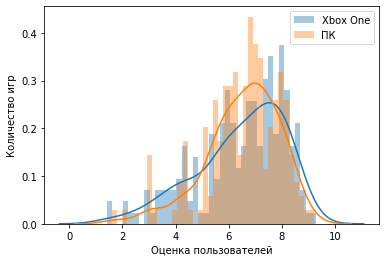

Средний рейтинг пользователей ПК: 6.45
Средний рейтинг пользователей XBox One: 6.52
Медиана рейтинга пользователей ПК: 6.80
Медиана рейтинга пользователей XBox One: 6.80


In [57]:
platform_test = st.ttest_ind(df5.query('platform == "XOne" and user_score == user_score')['user_score'], 
                             df5.query('platform == "PC" and user_score == user_score')['user_score'], 
                             equal_var = True)
print('p-значение: {:.2f}'.format(platform_test.pvalue))
if (platform_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

bins_xbox = df5.query('platform == "XOne"')['user_score'].max()*5 - df5.query('platform == "XOne"')['user_score'].min()*5 + 1
bins_xbox = bins_xbox.astype('int')
bins_pc = df5.query('platform == "PC"')['user_score'].max()*5 - df5.query('platform == "PC"')['user_score'].min()*5 + 1
bins_pc = bins_pc.astype('int')

ax = sns.distplot(df5.query('platform == "PC" and user_score == user_score')['user_score'], 
                  bins = bins_xbox, label = 'Xbox One')
ax = sns.distplot(df5.query('platform == "XOne" and user_score == user_score')['user_score'], 
                  bins = bins_pc, label = 'ПК')
ax.set(xlabel='Оценка пользователей', ylabel='Количество игр')
plt.legend()
plt.show()

print('Средний рейтинг пользователей ПК: {:.2f}'.format(df5.query('platform == "PC"')['user_score'].mean()))
print('Средний рейтинг пользователей XBox One: {:.2f}'.format(df5.query('platform == "XOne"')['user_score'].mean()))
print('Медиана рейтинга пользователей ПК: {:.2f}'.format(df5.query('platform == "PC"')['user_score'].median()))
print('Медиана рейтинга пользователей XBox One: {:.2f}'.format(df5.query('platform == "XOne"')['user_score'].median()))

Нулевая гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC не различаются, отвергнута. Это неудивительно, так как на обеих платформах выходят примерно одни и те же игры, а оцениваются сами игры, а не платформы. На гистограмме видно, что, несмотря на небольшие различия в распределении величин, и среднее, и медиана срваниваемых рейтингов почти совпадают. Вывод: средний пользовательский рейтинг платформы ПК совпадает с Xbox One. 

**Нулевая гипотеза: Средние пользовательские рейтинги жанров экшн и спорт не различаются**  
Альтернативная гипотеза: средние пользовательские рейтинги жанров экшн и спорт различаются  
Проверяю нулевую гипотезу с выбранным уровнем значимости, строю гистограмму распределения оценок.

p-значение: 0.00
Отвергаем нулевую гипотезу


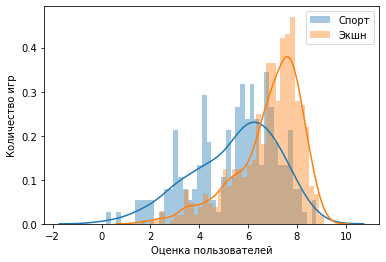

Средний рейтинг жанра спорт: 5.47
Средний рейтинг жанра экшн: 6.84
Медиана рейтинга жанра спорт: 5.80
Медиана рейтинга жанра экшн: 7.20


In [58]:
genre_test = st.ttest_ind(df5.query('genre == "Action" and user_score == user_score')['user_score'], 
                             df5.query('genre == "Sports" and user_score == user_score')['user_score'], 
                             equal_var = True)
print('p-значение: {:.2f}'.format(genre_test.pvalue))
if (genre_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

bins_action = df5.query('genre == "Action"')['user_score'].max()*5 - df5.query('genre == "Action"')['user_score'].min()*5 + 1
bins_action = bins_action.astype('int')
bins_sports = df5.query('genre == "Sports"')['user_score'].max()*5 - df5.query('genre == "Sports"')['user_score'].min()*5 + 1
bins_sports = bins_sports.astype('int')

ax = sns.distplot(df5.query('genre == "Sports" and user_score == user_score')['user_score'], 
                  bins = bins_sports, label = 'Спорт')
ax = sns.distplot(df5.query('genre == "Action" and user_score == user_score')['user_score'], 
                  bins = bins_action, label = 'Экшн')
ax.set(xlabel='Оценка пользователей', ylabel='Количество игр')
plt.legend()
plt.show()

print('Средний рейтинг жанра спорт: {:.2f}'.format(df5.query('genre == "Sports"')['user_score'].mean()))
print('Средний рейтинг жанра экшн: {:.2f}'.format(df5.query('genre == "Action"')['user_score'].mean()))
print('Медиана рейтинга жанра спорт: {:.2f}'.format(df5.query('genre == "Sports"')['user_score'].median()))
print('Медиана рейтинга жанра экшн: {:.2f}'.format(df5.query('genre == "Action"')['user_score'].median()))

Нулевая гипотеза о том, что средние пользовательские рейтинги жанров экшн и спорт не различаются, отвергнута. И среднее, и медиана отличаются на 1,3 пункта в пользу спорта, а на гистограмме видно, что оценки спортивных игр распределены более равномерно, чем экшн, большая часть значений которого расположена возле моды. Вывод: средний пользовательский рейтинг жанра экшн выше, чем у спортивных игр. В том числе поэтому экшн-игры держат первое место по продажам в мире.

## Шаг 6. Общий вывод

Всего рассмотрены 16712 игр на 31 платформе с 1980 по 2016 годы, из них детально - последние 5 лет, 2691 игра на 9 платформах.  
Средняя продолжительность жизни одной платформы - 10 лет, в 2016 году продавались игры для 4 групп платформ - ПК, PlayStation, Xbox и Nintendo, и 11 платформ (PS4, 3DS, XOne, WiiU, PS3, ПК, X360, PSV, Wii, DS, PSP).  
  
Максимальное количество продаж и по количеству, и по стоимости достигнуто в 2008 году, после чего объемы снижались до 2013 года, когда возобновился рост количества, стоимости и средней цены игры. Наиболее вероятно, что это произошло из-за снижения покупательной способности населения в результате финансового кризиса 2008 года, однако ни эту, ни одну другую гипотезу не получилось достоверно подтвердить.  
Другие выявленные временные тренды:  
- продажи игр увеличиваются за счет накопительного эффекта продаж в течение примерно 4 лет после выпуска игры: к концу года выхода игра в среднем собирает 39% выручки, за 2 года - 67%, за 3 - 86%, за 4 - полную выручку. За счет этого данные по продажам за 2013-2016 года неполные;
- данные за 2016 год как по количеству выпущенных игр, так и по их выручке, не полны;
- с 2013 года снижается доля портативных платформ, что может быть вызвано переходом аудитории на мобильные игры на смартфонах.

Учитывая снижение выручки более чем в два раза с 2008 года, остановившееся в 2013 году, и жизненный цикл платформы в 10 лет, дальнейший анализ проводился для данных за 5 лет и по 9 платформам (всем из списка выше, кроме последних двух). 
  
Количество выпускаемых игр, выручка и средняя выручка на пятилетнем горизонте:
- PS4 расчет за счет PS3 и лидирует по выручке (314 / 290 млн долл.), но отстает от PS3 по количеству игр (392 / 493)
- на 3-5 местах по выручке две консоли XBox и Nintendo 3DS (159 - 238 млн долл.), но по количеству игр 3DS на втором месте (397), а у XBox 360 и One - 294 и 247 соответственно. 
- в целом топ-5 платформ отвечают за 84% выручки и 68% количества игр. Такой разрыв - за счет ПК, средняя выручка игры для которого ниже консолей, и PSVita, на которой выпускаются почти все те же игры, что и на стационарных PS, но продаж гораздо меньше.  
- по средней выручке с игры лидируют главные стационарные консоли: X360, Wii, PS4
- среди портативных платформ лидирует WiiU, затем идет 3DS и значительно ниже PSVita
- по жанрам по выручке и количеству игр с большим отрывом лидирует экшн, также популярны RPG, шутеры и спортивные  
- средняя выручка на одну игру примерно одинаковая для всех жанров (0,53 млн долл.), только шутеры в среднем собирают больше выручки (1,29 млн долл. на 1 игру), а приключенческие игры - меньше (0,11 млн долл.). Это объясняется тем, что шутеры в среднем имеют более высокие рейтинги, а среди приключений есть большая доля продаваемых только в Японии.

Влияние рейтингов на выручку игр:
- оценки пользователей и критиков распределены примерно симметрично, то есть шкалы сопоставимы для сравнения
- однако рейтинг критиков сильнее влияет на выручку игр, чем рейтинг пользователей, так как оценки критиков выходят в первые дни появления игры.
- игры с оценкой критиков ниже 5 вообще не продаются, а оценка пользователей иногда расходится с продажами.
  
Сравнение по странам:  
В целом, предпочтения геймеров Европы и СА практически совпадают, за исключением того, что в Европе более популярны PS, в СА - XBox. Япония отличается по нескольким параметрам, например, в Японии 37% продаж приходится на игры, не продаваемые нигде больше.   
- Платформы: Япония тяготеет к карманным (3DS, PSV) приставкам, Европа - к PlayStation, а США - к XBox. Если японцы и покупают стационарные приставки, то это PlayStation, поэтому в продажах по всему миру PlayStation обгоняет XBox. Игры на ПК лучше всего продаются в Европе, в СА - меньше, а в Японии - вообще нет. На платформы за пределами топ-5 приходится менее 20% продаж. Уникальные для Японии игры выпускают в основном на тех платформах, которые там популярны - Nintendo 3DS, PS Vita, PS3. 
- Жанры: экшн составляет 30% продаж во всех регионах, шутер и RPG - еще 35%, спортивные и прочие - 15%, таким образом, топ- жанров составляет 80% продаж (если можно учитывать прочие как один жанр). Доли отдельных жанров в Европе и СА практически совпадают, а в Японии лидирует RPG за счет того, что он этот жанр более распространен на портативных приставках, популряных в Японии. 20% местных японских игр - в жанре приключений с незначительной выручкой, предположительно, это простые аркадные игры. 
- Рейтинг: В Европе и СА, а также в мире в целом, наиболее популярны игры для взрослых (от 17 лет), 45%, для аудитории всех возрастов - еще 25%. В Японии игры рейтингов 0, 13+ и 17+ распределены примерно одинаково - по 25%-30%. Это происходит за счет того, что большинство уникальных для Японии игр (из тех, что получили рейтинг ESRB) имеют рейтинг 13+.  
Итого, топ-5 наиболее популярных жанров, платформ и групп рейтинга составляют примерно 80% продаж. В Японии популряны другие платформы, в остальном глобадбные игры продаются в Японии примерно так же, как и в Европе и СА, однако уникальные для Японии игры полностью отличаются. В Европе и СА почти нет своих укниальных игр.  
  
Проверка гипотез:  
1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - **гипотеза не опровегрнута**  
2) Средние пользовательские рейтинги жанров Экшн и Спорт разные **гипотеза подтверждена**  
  
**Комментарий по распределению рекламного бюджета:**  
Предположительно, рекламный бюджет должен распределяться пропорционально ожидаемой выручке. За счет накопительного эффекта в 2017 году вероятна выручка на уровне не ниже 2013 года (357 млн долл.), причем на новые игры придется только порядка 39% от нее, остальное - на игры предыдущих лет.  
Показатели PS3, Wii и X360 снижаются, а цикл жизни подходит к концу, целесообразно снижать рекламу игр на этих платформах в пользу лидера - PS4 - и XOne, который должен по всем показателям обогнать X360. Однако, если важен не объем выручки на платформу, а выручка на конкретную игру, то выгоднее рекламировать XBox, так как у него самая высокая средняя выручка на игру. Несмотря на большую выручку Nintendo 3DS, доля портативных платформ снижается на протяжении нескольких лет и можно ожидать дальнейшего сокращения, а средняя выручка ниже, чем на стационарных консолях. Исключение составляет рынок Японии, на котором портативные консоли очень популярны. Япония обладает своими особенностями, там можно рекламировать, во-первых, глобальные игры, но для популярных именно в Японии платформ, а во-вторых, местные игры.   
Рейтинг игроков можно не учитывать, так как продажи игр определяются в значительной степени рейтингами критиков. Рекламировать игры с рейтингом ниже 5 бесполезно, лучше начинать с 7. Среди возрастных рейтингов лидируют игры для взрослых (17+) и игры без ограничений, однако большая часть игр, особенно японских, не имеет рейтинга и поэтому не стоит полагаться на этот показатель.    
Среди жанров топ-5 во главе с action охватывает 80% продаж, однако в рекламе лучше ориентироваться на среднюю выручку одной игры, которая выше всех у шутеров.